### Improving the Best Classifier - Decision Tree

In the previous module, it was found out that Decision Trees are the best classifiers for the problem of detecting frauds. But, a classic decision tree still had a testing F1 score of 0.8718946256877674

To further imrpove this score, ensemble models based on Decision trees may be applied on the data. In this section, we will look at 5 different types of ensemble models for Decision trees and evaluate their best hyperparameters:

Basic Decision Tree

Bagging Classifier

Random Forest Classifier

Gradient Boosting Classifier

XG Boost Classifier

Note: For XGBoost classifier, the xgboost library is needed. To install it, open Powershell prompt in Anaconda navigator and run the command below:

conda install -c anaconda py-xgboost

approx runtime of notebook ~ 50mins

In [ ]:
please note that for XGBoost, 

In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn import metrics
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def refine_df (input_df):
    input_df.drop("Unnamed: 0", 1, inplace=True)
    input_df=input_df.replace(np.NaN, 0)
    input_df=input_df.replace('No', 0)
    input_df=input_df.replace('Yes', 1)
    return input_df

In [3]:
def K_Fold_And_Print_Metrics(mlp_clf, X, y, useMinMax=True):
    kfold = model_selection.KFold(5, shuffle=True, random_state=2)

    prec, rec, f1 = [], [], []

    for train_idx, test_idx in kfold.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
        if(useMinMax):
            X_scaler = preprocessing.MinMaxScaler()
            X_train = X_scaler.fit_transform(X_train)
            X_test = X_scaler.transform(X_test)
    
        print("fitting iteration")
        mlp_clf.fit(X_train, y_train)
        y_pred = mlp_clf.predict(X_test)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0, 1]).ravel()
        print(tn, fp, fn, tp)
        
        
    
        #print(y_pred)
        #print(y_test)
    
        rec += [metrics.recall_score(y_test, y_pred, average="binary")]
        prec += [metrics.precision_score(y_test, y_pred, average="binary")]
        f1 += [metrics.f1_score(y_test, y_pred, average="binary")]
    
        #print()

    print("recall    = {:.4f} ±{:.4f}".format(np.mean(rec), np.std(rec)))
    print("precision = {:.4f} ±{:.4f}".format(np.mean(prec), np.std(prec)))
    print("f1        = {:.4f} ±{:.4f}".format(np.mean(f1), np.std(f1)))

The first sampled set was used in the last module, the second set is used in this one. Since all of the sets have been sampled using the same technique, we can expect a similar metric for decision trees for this sample as well

In [4]:
df = pd.read_csv("Datasets/ohe_sampled_cc_2.csv")
df

,Unnamed: 0,Merchant_State=AA,Merchant_State=AK,Merchant_State=AL,Merchant_State=AR,Merchant_State=AZ,Merchant_State=Albania,Merchant_State=Algeria,Merchant_State=Andorra,Merchant_State=Angola,...,Month,Day,Time,Amount,Merchant_Name,Merchant_City,Zip,MCC,Errors,Is_Fraud
0,0,0,0,0,0,0,0,0,0,0,...,11,15,12,287.13,-8194607650924472520,45373,45373,3001,284097,Yes
1,1,0,0,0,0,0,0,0,0,0,...,11,15,13,2.41,-7759074308363763111,45373,45373,5651,284097,Yes
2,2,0,0,0,0,0,0,0,0,0,...,11,16,9,50.81,-551332107213382088,45373,45373,4411,284097,Yes
3,3,0,0,0,0,0,0,0,0,0,...,11,16,9,248.36,4872340518840476610,45373,45373,5732,284097,Yes
4,4,0,0,0,0,0,0,0,0,0,...,11,16,11,473.00,-8566951830324093739,45373,45373,3640,284097,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289350,289350,0,0,0,0,0,0,0,1,0,...,10,20,13,36.90,8263593753316459353,32,32,5411,284097,No
289351,289351,0,0,0,0,0,0,0,1,0,...,10,21,21,47.64,2714206426893853043,32,32,5813,284097,No
289352,289352,0,0,0,0,0,0,0,1,0,...,10,14,12,29.64,8263593753316459353,32,32,5411,284097,No
289353,289353,0,0,0,0,0,0,0,1,0,...,10,14,13,26.22,8263593753316459353,32,32,5411,284097,No


In [5]:
df = refine_df(df)

In [6]:
y= df["Is_Fraud"]  
X= df.drop(["Is_Fraud"],axis=1)

from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, train_size=0.7, random_state=42)
sss.get_n_splits(X, y)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [ 81552   3115 245214 ... 220560 256491 222392] TEST: [134707  31737  11583 ... 277104  99103  76128]
TRAIN: [108657   6588 125819 ... 152267 287572  79673] TEST: [ 95062  45320 258510 ... 234765 244316 180534]
TRAIN: [202241  31590  26856 ... 130497 282732 218468] TEST: [275309  51783 200654 ... 202459 134903 255378]
TRAIN: [148381 138350  64153 ... 192190  11160  41059] TEST: [ 46472  56413  78457 ... 137844 167112 226027]
TRAIN: [197398 125668 150899 ... 115911 157136 113472] TEST: [ 30426 259067 251528 ... 229996 133665 191321]


fitting iteration
35793 528 514 3675
fitting iteration
35814 562 506 3628
fitting iteration
35791 534 486 3699
fitting iteration
35816 539 517 3637
fitting iteration
35796 545 534 3634
recall    = 0.8772 ±0.0039
precision = 0.8709 ±0.0031
f1        = 0.8741 ±0.0029

------ Test Scores: -------
[0.878122549568724]
[0.8760616897630755]
[0.8770909090909089]


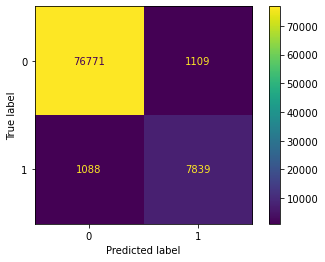

In [7]:
from sklearn import tree

infoGain_clf= sklearn.tree.DecisionTreeClassifier(criterion='entropy')

K_Fold_And_Print_Metrics(infoGain_clf, X_train, y_train, False)

plot_confusion_matrix(infoGain_clf, X_test, y_test)

y_pred = infoGain_clf.predict(X_test)
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

As expected, the f1 score of a normal Decision Tree in this dataset is close to the one for the last dataset, which was 0.8718946256877674

### Evaluating Hyperparameters and Testing Scores

For evaluating Hyperparameters, we will only use a subset of the loaded csv data for faster computation. Since we plan to use GridSearchCV for our analysis, we can expect a lot of fits and hence, a smaller chunk of data will be used to evaluate the best hyperparameters then the testing scores of each module will be seen.

In [8]:
y_train[:10000].value_counts()

0    8975
1    1025
Name: Is_Fraud, dtype: int64

In [9]:
evaluation_index = 10000

First we look at the scores by fitting a normal decision tree on the smaller chunk of data to get a rough measure of what the scores will be like on the scaled down data

fitting iteration
1754 39 50 157
fitting iteration
1745 36 46 173
fitting iteration
1760 40 34 166
fitting iteration
1755 41 37 167
fitting iteration
1759 46 44 151
recall    = 0.7943 ±0.0267
precision = 0.8008 ±0.0197
f1        = 0.7973 ±0.0188

------ Test Scores: -------
[0.8110227400022404]
[0.814123467896098]
[0.8125701459034792]


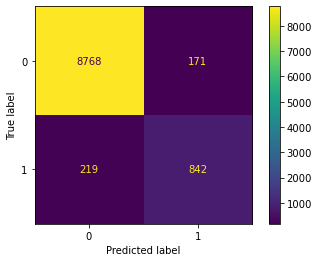

In [10]:
from sklearn import tree

infoGain_clf= sklearn.tree.DecisionTreeClassifier(criterion='entropy')

K_Fold_And_Print_Metrics(infoGain_clf, X_train[:evaluation_index], y_train[:evaluation_index], False)

plot_confusion_matrix(infoGain_clf, X_test[:evaluation_index], y_test[:evaluation_index])

y_pred = infoGain_clf.predict(X_test)
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

### Bagging Classifier

In [11]:
from sklearn.ensemble import BaggingClassifier

params = {"base_estimator__criterion": ['gini', 'entropy'], 
          "n_estimators": [5, 10, 20]}

bagged_clf = BaggingClassifier(base_estimator=infoGain_clf, random_state=7)

#bagged_clf.get_params()

grid_bagged = GridSearchCV(estimator=bagged_clf, cv=5, param_grid=params, scoring='f1', n_jobs=-1, verbose=1)

grid_bagged.fit(X_train[:evaluation_index], y_train[:evaluation_index])
#Printing best hyperparameters
print("Best f1: ", grid_bagged.best_score_)
print("Best hyperparameters: ", grid_bagged.best_params_)
y_pred = grid_bagged.predict(X_test[:evaluation_index])
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.precision_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.f1_score(y_test[:evaluation_index], y_pred, average="binary")] )

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best f1:  0.8564045100492116
Best hyperparameters:  {'base_estimator__criterion': 'entropy', 'n_estimators': 20}

------ Test Scores: -------
[0.7841658812441094]
[0.942242355605889]
[0.8559670781893004]


In [12]:
grid_bagged.best_estimator_.fit(X_train, y_train)
y_pred = grid_bagged.best_estimator_.predict(X_test)

print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

------ Test Scores: -------
[0.873865800380867]
[0.96415770609319]
[0.9167939828416969]


### Random Forest Classifier

fitting iteration
36086 235 775 3414
fitting iteration
36164 212 735 3399
fitting iteration
36105 220 735 3450
fitting iteration
36131 224 736 3418
fitting iteration
36097 244 731 3437
recall    = 0.8218 ±0.0035
precision = 0.9378 ±0.0028
f1        = 0.8760 ±0.0026

------ Test Scores: -------
[0.8295059930547777]
[0.9409148665819568]
[0.8817050663809014]


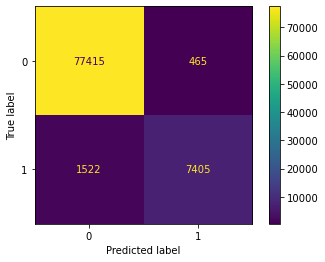

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs = -1)

K_Fold_And_Print_Metrics(rf_clf, X_train, y_train, False)

plot_confusion_matrix(rf_clf, X_test, y_test)

y_pred = rf_clf.predict(X_test)
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

In [14]:
params = {"criterion": ['gini', 'entropy'], "n_estimators": [100, 200, 500, 1000]}


grid_rf = GridSearchCV(estimator=rf_clf, cv=5, param_grid=params, scoring='f1', n_jobs=-1, verbose=1)

grid_rf.fit(X_train[:evaluation_index], y_train[:evaluation_index])
#Printing best hyperparameters
print("Best f1: ", grid_rf.best_score_)
print("Best hyperparameters: ", grid_rf.best_params_)
y_pred = grid_rf.predict(X_test[:evaluation_index])
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.precision_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.f1_score(y_test[:evaluation_index], y_pred, average="binary")] )

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best f1:  0.802349702408843
Best hyperparameters:  {'criterion': 'entropy', 'n_estimators': 200}

------ Test Scores: -------
[0.7417530631479736]
[0.8773690078037905]
[0.8038815117466803]


In [15]:
grid_rf.best_estimator_.fit(X_train, y_train)
y_pred = grid_rf.best_estimator_.predict(X_test)

print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

------ Test Scores: -------
[0.8335387028116948]
[0.9436905516804058]
[0.8852010468712824]


### Gradient Boosting Classifier

fitting iteration
35951 370 922 3267
fitting iteration
36050 326 892 3242
fitting iteration
36007 318 917 3268
fitting iteration
36019 336 868 3286
fitting iteration
35962 379 876 3292
recall    = 0.7852 ±0.0045
precision = 0.9044 ±0.0058
f1        = 0.8406 ±0.0033

------ Test Scores: -------
[0.7993726895933684]
[0.9050095117311351]
[0.8489174399238639]


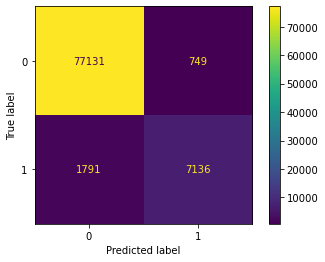

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

K_Fold_And_Print_Metrics(gb_clf, X_train, y_train, False)

plot_confusion_matrix(gb_clf, X_test, y_test)

y_pred = gb_clf.predict(X_test)
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

In [18]:
params = {"n_estimators": [50, 100, 200, 500]}


grid_gb = GridSearchCV(estimator=gb_clf, cv=5, param_grid=params, scoring='f1', n_jobs=-1, verbose=1)

grid_gb.fit(X_train[:evaluation_index], y_train[:evaluation_index])
#Printing best hyperparameters
print("Best f1: ", grid_gb.best_score_)
print("Best hyperparameters: ", grid_gb.best_params_)
y_pred = grid_gb.predict(X_test[:evaluation_index])
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.precision_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.f1_score(y_test[:evaluation_index], y_pred, average="binary")] )

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best f1:  0.8648581338447737
Best hyperparameters:  {'n_estimators': 500}

------ Test Scores: -------
[0.8152686145146089]
[0.9172852598091198]
[0.8632734530938123]


In [19]:
grid_gb.best_estimator_.fit(X_train, y_train)
y_pred = grid_gb.best_estimator_.predict(X_test)

print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

------ Test Scores: -------
[0.8581830402150779]
[0.9567878106656675]
[0.9048068973662454]


### XGBoost Classifier

In [20]:
from xgboost.sklearn import XGBClassifier
from scipy import stats

xgb = XGBClassifier()

In [21]:
params = {"n_estimators": [50, 100, 200, 500]}


grid_xg = GridSearchCV(estimator=xgb, cv=5, param_grid=params, scoring='f1', n_jobs=-1, verbose=1)

grid_xg.fit(X_train[:evaluation_index], y_train[:evaluation_index])
#Printing best hyperparameters
print("Best f1: ", grid_xg.best_score_)
print("Best hyperparameters: ", grid_xg.best_params_)
y_pred = grid_xg.predict(X_test[:evaluation_index])
print()
print("------ Test Scores: -------")
print( [metrics.recall_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.precision_score(y_test[:evaluation_index], y_pred, average="binary")] )
print ( [metrics.f1_score(y_test[:evaluation_index], y_pred, average="binary")] )

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[10:36:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best f1:  0.8651531601013968
Best hyperparameters:  {'n_estimators': 200}

------ Test Scores: -------
[0.8143261074458058]
[0.9320388349514563]
[0.869215291750503]


In [22]:
grid_xg.best_estimator_.fit(X_train, y_train)
y_pred = grid_xg.best_estimator_.predict(X_test)

print("------ Test Scores: -------")
print( [metrics.recall_score(y_test, y_pred, average="binary")] )
print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
print ( [metrics.f1_score(y_test, y_pred, average="binary")] )

[10:36:54] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------ Test Scores: -------
[0.9118404839251708]
[0.9675502198977772]
[0.9388696655132641]


In [23]:
def print_metrics(y_test, y_pred):
    print("------ Test Scores: -------")
    print( [metrics.recall_score(y_test, y_pred, average="binary")] )
    print ( [metrics.precision_score(y_test, y_pred, average="binary")] )
    print ( [metrics.f1_score(y_test, y_pred, average="binary")] )
    print()

### Oversampling the Data

It can be seen clearly that ensemble methods result in better performance than a sole Decision tree. But the highest score is still 0.9388696655132641. There is still scope to improve this score. We balanced the class after the exploratory analysis by undersampling the data. Now to further balance the classes, we use the technique of 'oversampling'. The technique used here for oversampling and generating synthetic data for the imbalanced class is ADASYN. For running this, imblearn library is required to be installed. 

To install the library, simply open a Powershell Prompt in Anaconda navigator and run the command below:

conda install -c conda-forge imbalanced-learn

In [24]:
from imblearn import over_sampling

ada = over_sampling.ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train, y_train)
X_test_adasyn, y_test_adasyn = ada.fit_resample(X_test, y_test)

In [25]:
def get_metrics(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_metrics(y_test, y_pred)

Now we evaluate the performance of all models with their best parameters on the balanced data generated by ADASYN

In [26]:
print("Decision Tree")
get_metrics(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, infoGain_clf)
print("XG Boost")
get_metrics(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, grid_xg.best_estimator_)
print("Gradient Boosting")
get_metrics(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, grid_gb.best_estimator_)
print("Random Forest")
get_metrics(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, grid_rf.best_estimator_)
print("Bagged Boosting")
get_metrics(X_train_adasyn, y_train_adasyn, X_test_adasyn, y_test_adasyn, grid_bagged.best_estimator_)

Decision Tree
------ Test Scores: -------
[0.955068975334524]
[0.976436500271225]
[0.9656345473220068]

XG Boost
[10:40:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
------ Test Scores: -------
[0.978621528586588]
[0.991178976341831]
[0.9848602256965924]

Gradient Boosting
------ Test Scores: -------
[0.9644770556720242]
[0.9829339382509265]
[0.9736180330117508]

Random Forest
------ Test Scores: -------
[0.9599865413981417]
[0.9872898838122364]
[0.9734467984594287]

Bagged Boosting
------ Test Scores: -------
[0.9589900872220928]
[0.9909867743617861]
[0.974725917936509]



Therefore, after oversampling the data by applying ADASYN, it is evident that the XGBoost performs the best with an f1 score of 0.984860. Now, we need to see its performance over the entire sampled dataset with its best parameters obtained (n_estimators=200)